# Trial with Graph Convolutional Network

## 方針

### 教師あり学習

まずは教師あり学習により強いポリシーを獲得。

### 自己対戦による訓練

* Q関数が相手によって変わってしまう。
    * On-policyで自己対戦にすればOK。Off-policyにしたい場合は、Q関数が大きく違わない過去エピソードとすべき。
        * Rainbow
            * PFRLに実装あり。まずはこれ？
        * MuZero
            * 実装少し大変かも。だが自己対戦による実績あるため性能は出るかも？
    * Policyを持つアルゴリズムならOK。相手ごとにQ関数を学習すれば良い。この場合も自己対戦かつOn-policy。
        * AC3、PPOなど
            * PFRLに実装あり。これもトライ？
            
### 方策／Q関数モデル

* Graph Neural Network
    * あたかもそれぞれの選手が行動判断／価値判断しているようなモデルにする。選択されたアクションは、その時Activeな選手の最善手とする。
    * 初めは、特徴量は、絶対位置座標で、完全グラフを用いる。

## Actions

### Default action set

The default action set consists of 19 actions:

*   Idle actions

    *   `action_idle` = 0, a no-op action, stickly actions are not affected (player maintains his directional movement etc.).

*   Movement actions

    *   `action_left` = 1, run to the left, sticky action.
    *   `action_top_left` = 2, run to the top-left, sticky action.
    *   `action_top` = 3, run to the top, sticky action.
    *   `action_top_right` = 4, run to the top-right, sticky action.
    *   `action_right` = 5, run to the right, sticky action.
    *   `action_bottom_right` = 6, run to the bottom-right, sticky action.
    *   `action_bottom` = 7, run to the bottom, sticky action.
    *   `action_bottom_left` = 8, run to the bottom-left, sticky action.

*   Passing / Shooting

    *   `action_long_pass` = 9, perform a long pass to the player on your team. Player to pass the ball to is auto-determined based on the movement direction.
    *   `action_high_pass` = 10, perform a high pass, similar to `action_long_pass`.
    *   `action_short_pass` = 11, perform a short pass, similar to `action_long_pass`.
    *   `action_shot` = 12, perform a shot, always in the direction of the opponent's goal.

*   Other actions

    *   `action_sprint` = 13, start sprinting, sticky action. Player moves faster, but has worse ball handling.
    *   `action_release_direction` = 14, reset current movement direction.
    *   `action_release_sprint` = 15, stop sprinting.
    *   `action_sliding` = 16, perform a slide (effective when not having a ball).
    *   `action_dribble` = 17, start dribbling (effective when having a ball), sticky action. Player moves slower, but it is harder to take over the ball from him.
    *   `action_release_dribble` = 18, stop dribbling.

### V2 action set

It is an extension of the default action set:

*   `action_builtin_ai` = 19, let game's built-in AI generate an action

In [1]:
# Install:
# Kaggle environments.
!git clone https://github.com/Kaggle/kaggle-environments.git
!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v2.3 https://github.com/google-research/football.git
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.3.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

fatal: destination path 'kaggle-environments' already exists and is not an empty directory.
Processing /notebooks/kaggle/gfootball/kaggle-environments
  Created wheel for kaggle-environments: filename=kaggle_environments-1.3.14-py3-none-any.whl size=302295 sha256=11b813c7772209ea2ae363ef2e8fa4ec6206272e4fdd64f1c0d5fdd2657f2492
  Stored in directory: /root/.cache/pip/wheels/32/ff/b6/a9ab62cd5f60b2492aa5d5bc96a6d12bb1158496e87a4576ec
Successfully built kaggle-environments
  Attempting uninstall: kaggle-environments
    Found existing installation: kaggle-environments 1.3.14
    Uninstalling kaggle-environments-1.3.14:
      Successfully uninstalled kaggle-environments-1.3.14
Ign:1 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 http://developer.download.nvi

## Install

In [2]:
!pip install pfrl==0.1.0

In [3]:
# ------------------ install torch_geometric begin -----------------
try:
    import torch_geometric
except:
    import subprocess
    import torch

    nvcc_stdout = str(subprocess.check_output(['nvcc', '-V']))
    tmp = nvcc_stdout[nvcc_stdout.rfind('release') + len('release') + 1:]
    cuda_version = tmp[:tmp.find(',')]
    cuda = {
            '9.2': 'cu92',
            '10.1': 'cu101',
            '10.2': 'cu102',
            }

    CUDA = cuda[cuda_version]
    TORCH = torch.__version__.split('.')
    TORCH[-1] = '0'
    TORCH = '.'.join(TORCH)

    install1 = 'pip install torch-scatter==latest+' + CUDA + ' -f https://pytorch-geometric.com/whl/torch-' + TORCH + '.html'
    install2 = 'pip install torch-sparse==latest+' + CUDA + ' -f https://pytorch-geometric.com/whl/torch-' + TORCH + '.html'
    install3 = 'pip install torch-cluster==latest+' + CUDA + ' -f https://pytorch-geometric.com/whl/torch-' + TORCH + '.html'
    install4 = 'pip install torch-spline-conv==latest+' + CUDA + ' -f https://pytorch-geometric.com/whl/torch-' + TORCH + '.html'
    install5 = 'pip install torch-geometric'

    subprocess.run(install1.split())
    subprocess.run(install2.split())
    subprocess.run(install3.split())
    subprocess.run(install4.split())
    subprocess.run(install5.split())
# ------------------ install torch_geometric end -----------------

In [4]:
import os
import cv2
import sys
import glob 
import random
import json
import pickle
import imageio
import pathlib
import collections
from collections import deque
import numpy as np
import pandas as pd
import argparse
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
sns.set()
%matplotlib inline

from gym import spaces
from tqdm import tqdm
from logging import getLogger, StreamHandler, FileHandler, DEBUG, INFO
from typing import Union, Callable, List, Tuple, Iterable, Any, Dict
from dataclasses import dataclass
from IPython.display import Image, display
sns.set()


# PFRL
import pfrl
from pfrl.agents import CategoricalDoubleDQN
from pfrl import experiments
from pfrl import explorers
from pfrl import nn as pnn
from pfrl import utils
from pfrl import replay_buffers
from pfrl.wrappers import atari_wrappers
from pfrl.q_functions import DistributionalDuelingDQN

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F

# PyTorch geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import RGCNConv
from torch_geometric.data import InMemoryDataset

# Env
import gym
import gfootball
import gfootball.env as football_env
from gfootball.env import observation_preprocessing
from gfootball.env.wrappers import Simple115StateWrapper

## Config

In [5]:
# Check we can use GPU
print(torch.cuda.is_available())

# set gpu id
if torch.cuda.is_available(): 
    # NOTE: it is not number of gpu but id which start from 0
    gpu = 0
else:
    # cpu=>-1
    gpu = -1

True


In [6]:
# set logger
def logger_config():
    logger = getLogger(__name__)
    handler = StreamHandler()
    handler.setLevel("DEBUG")
    logger.setLevel("DEBUG")
    logger.addHandler(handler)
    logger.propagate = False

    filepath = './result.log'
    file_handler = FileHandler(filepath)
    logger.addHandler(file_handler)
    return logger

logger = logger_config()

In [7]:
# fixed random seed
# but this is NOT enough to fix the result of rewards.Please tell me the reason.
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    utils.set_random_seed(seed)  # for PFRL
    
# Set a random seed used in PFRL.
seed = 5046
seed_everything(seed)

# Set different random seeds for train and test envs.
train_seed = seed
test_seed = 2 ** 31 - 1 - seed

## Environment

In [8]:
env = football_env.create_environment(
    env_name='11_vs_11_easy_stochastic',  # easy mode
    stacked=False,
    representation='simple115v2',           # SMM
    rewards='scoring, checkpoints',
    write_goal_dumps=False,
    write_full_episode_dumps=False,
    render=False,
    write_video=False,
    dump_frequency=1,
    logdir='./',
    extra_players=None,
    number_of_left_players_agent_controls=1,
    number_of_right_players_agent_controls=0,
)

In [9]:
array = env.reset()

In [10]:
obs, _, _, info = env.step(1)

## GCN-Policy

The flag to distinguish left players, right players, and the ball.

* left players: 0
* right players: 1
* ball: 2

In [11]:
relations_dict = {
    (0., 0.): 0, # left player -> left player
    (0., 1.): 1, # left player -> right player
    (0., 2.): 2, # left player -> ball
    (1., 0.): 3, # right player -> left player
    (1., 1.): 4, # right player -> right player
    (1., 2.): 5, # right player -> ball
    (2., 0.): 6, # ball -> left player
    (2., 1.): 7, # ball -> right player
}

In [43]:
def create_graph_from_observation(state, action=None):
    array = state[0]
    
    left_coordinations = np.concatenate([array[:22].reshape(11, 2), np.zeros((11, 1))], axis=-1)
    left_directions = np.concatenate([array[22:44].reshape(11, 2), np.zeros((11, 1))], axis=-1)
    right_coordinations = np.concatenate([array[44:66].reshape(11, 2), np.zeros((11, 1))], axis=-1)
    right_directions = np.concatenate([array[66:88].reshape(11, 2), np.zeros((11, 1))], axis=-1)
    ball_coordination = array[88:91].reshape([1, 3])
    ball_direction = array[91:94].reshape([1, 3])
    ball_ownership = array[94:97] # none, left, right
    active_player = array[97:108].reshape([11, 1])
    game_mode = array[108:]

    # Node features
    left_features = np.concatenate([
        0*np.ones((11, 1)),
        left_coordinations,
        left_directions,
        ball_ownership[1]*np.ones((11, 1)),
        active_player,
    ], axis=-1)
    right_features = np.concatenate([
        1*np.ones((11, 1)),
        right_coordinations,
        right_directions,
        ball_ownership[2]*np.ones((11, 1)),
        np.zeros((11, 1)),
    ], axis=-1)
    ball_features = np.concatenate([
        2*np.ones((1, 1)),
        ball_coordination,
        ball_direction,
        np.zeros((1, 1)),
        np.zeros((1, 1)),
    ], axis=-1)

    features = np.concatenate([left_features, right_features, ball_features], axis=0)

    # Edges and relations
    X, Y = np.meshgrid(np.arange(len(features)), np.arange(len(features)))
    all_combinations = np.vstack([X.flatten(), Y.flatten()]).T
    edge_index = np.array(
        [combination for combination in all_combinations if not combination[0] == combination[1]]
    ).T
    types_for_edge_index = features[edge_index][:,:,0]
    relations = [relations_dict[tuple(types)] for types in types_for_edge_index.T]

    # numpy array to torch tensor
    features = torch.tensor(features, dtype=torch.float).contiguous()
    edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()
    relations = torch.tensor(relations, dtype=torch.long).contiguous()

    if action is None:
        graph = Data(x=features, edge_index=edge_index, edge_type=relations)

    else:
        graph = Data(x=features, edge_index=edge_index, edge_type=relations, y=torch.tensor(action, dtype=torch.long))

    return graph

In [29]:
class Policy(torch.nn.Module):
    def __init__(self, num_features, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(num_features - 2, 256, num_relations=num_relations)
        #self.conv2 = RGCNConv(128, 256, num_relations=num_relations)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 19)

    def forward(self, data):
        x, edge_index, edge_type = data.x, data.edge_index, data.edge_type
        flag = x[:,0]
        is_active = x[:,-1]
        x = x[:,1:-1]

        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)

        #x = self.conv2(x, edge_index, edge_type)
        #x = F.relu(x)
        
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        return F.log_softmax(x[is_active.bool()], dim=1)

## Supervised Learning

In [14]:
class FootballDataset(InMemoryDataset):
    def __init__(self, root, raw_file_names, processed_file_name, transform=None, pre_transform=None):
        self._raw_file_names = raw_file_names
        self._processed_file_names = [processed_file_name]
        super(FootballDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return self._raw_file_names

    @property
    def processed_file_names(self):
        return self._processed_file_names
    
    def process(self):
        data_list = []
        for raw_path in tqdm(self.raw_paths): # To fit in memory
            with open(raw_path, 'rb') as f:
                datum = pickle.load(f)
            for state, action in zip(datum['state'], datum['action']):
                if action != []:
                    data_list.append(create_graph_from_observation(state, action))
                    
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [15]:
random.seed(10)
all_file_names = sorted([pathlib.Path(path).name for path in glob.glob('./dataset/raw/*.pickle')])
random.shuffle(all_file_names)

In [16]:
def process(i, file_names):
    _ = FootballDataset('./dataset', file_names, 'dataset-{}.pt'.format(i))

In [17]:
processes = []
for i, file_names in enumerate(zip(*[iter(all_file_names)]*100)):
    processes.append(delayed(process)(i, file_names))
Parallel(n_jobs=2, verbose=10)(processes)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  3.1min
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  6.9min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 15.7min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 24.3min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 38.3min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 49.6min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 65.6min
[Parallel(n_jobs=2)]: Done  46 out of  46 | elapsed: 80.1min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [19]:
def get_dataset(i):
    return FootballDataset('./dataset', None, 'dataset-{}.pt'.format(i))

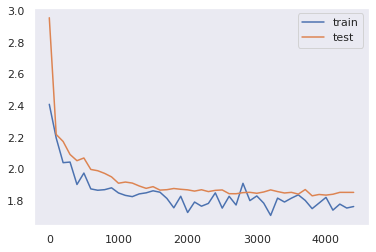

In [30]:
policy = Policy(num_features=9, num_relations=len(relations_dict))
optimizer = torch.optim.Adam(policy.parameters(), lr=0.001, weight_decay=5e-4)

policy.to('cuda')
episode = 0
episodes = []
steps_val = []
losses = []
losses_val = []


dataset_val = get_dataset(45)
loader_val = DataLoader(dataset_val, batch_size=2048, shuffle=True)

for dataset_num in range(45):
    dataset = get_dataset(dataset_num)
    loader = DataLoader(dataset, batch_size=1024, shuffle=True)
    
    policy.eval()
    losses_for_avg = []
    for data in loader_val:
        data.to('cuda')
        optimizer.zero_grad()
        log_softmax = policy(data)
        loss = F.nll_loss(log_softmax, data.y)
        losses_for_avg.append(loss.to('cpu').detach().numpy())
    episodes.append(episode)
    losses_val.append(np.mean(losses_for_avg))
    
    policy.train()
    losses_for_avg = []
    for data in loader:
        data.to('cuda')
        optimizer.zero_grad()
        log_softmax = policy(data)
        loss = F.nll_loss(log_softmax, data.y)
        loss.backward()
        optimizer.step()
        losses_for_avg.append(loss.to('cpu').detach().numpy())
    losses.append(np.mean(losses_for_avg))
    
    episode += 100

    clear_output()
    plt.plot(episodes, losses, label='train')
    plt.plot(episodes, losses_val, label='test')
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

In [42]:
policy_path = 'policy.pt'
torch.save(policy.to('cpu').state_dict(), policy_path)

## Trial

In [85]:
def agent(obs):
    global policy
    
    # Get observations for the first (and only one) player we control.
    #obs = Simple115StateWrapper.convert_observation(obs['players_raw'], True)
    graph = create_graph_from_observation(obs)
    actions = policy(graph)
    action = int(np.argmax(actions.detach().numpy()))
    return [action]

In [107]:
env = football_env.create_environment(
    env_name='11_vs_11_easy_stochastic',  # easy mode
    stacked=False,
    representation='simple115v2',
    rewards='scoring',
    write_goal_dumps=False,
    write_full_episode_dumps=False,
    render=False,
    write_video=False,
    dump_frequency=1,
    logdir='./',
    extra_players=None,
    number_of_left_players_agent_controls=1,
    number_of_right_players_agent_controls=0
)

In [ ]:
scores = []
for _ in tqdm(range(50)):
    obs = env.reset()
    rewards = []
    while True:
        action = agent([obs])
        obs, reward, done, info = env.step(action)
        rewards.append(reward)
        if done:
            break
    score = (np.sum(np.array(rewards) > 0), np.sum(np.array(rewards) < 0))
    print(score)
    scores.append(score)

  2%|▏         | 1/50 [00:36<30:05, 36.86s/it]

(4, 0)


  4%|▍         | 2/50 [01:13<29:22, 36.72s/it]

(3, 0)


  6%|▌         | 3/50 [01:50<28:50, 36.82s/it]

(3, 0)


  8%|▊         | 4/50 [02:27<28:23, 37.02s/it]

(4, 0)


 10%|█         | 5/50 [03:04<27:39, 36.88s/it]

(1, 0)


 12%|█▏        | 6/50 [03:41<27:09, 37.03s/it]

(1, 0)


 14%|█▍        | 7/50 [04:18<26:34, 37.07s/it]

(3, 0)


 16%|█▌        | 8/50 [04:56<25:59, 37.13s/it]

(0, 0)


 18%|█▊        | 9/50 [05:33<25:20, 37.09s/it]

(2, 1)


 20%|██        | 10/50 [06:10<24:40, 37.02s/it]

(2, 0)


 22%|██▏       | 11/50 [06:47<24:05, 37.08s/it]

(2, 1)


 24%|██▍       | 12/50 [07:24<23:29, 37.10s/it]

(4, 1)


 26%|██▌       | 13/50 [08:01<22:53, 37.13s/it]

(3, 0)


 28%|██▊       | 14/50 [08:38<22:18, 37.19s/it]

(1, 0)


 30%|███       | 15/50 [09:18<22:02, 37.78s/it]

(1, 1)


 32%|███▏      | 16/50 [09:57<21:39, 38.22s/it]

(2, 1)


 34%|███▍      | 17/50 [10:36<21:09, 38.47s/it]

(2, 0)


 36%|███▌      | 18/50 [11:13<20:20, 38.13s/it]

(4, 1)


 38%|███▊      | 19/50 [11:50<19:31, 37.78s/it]

(3, 2)


 40%|████      | 20/50 [12:27<18:44, 37.50s/it]

(3, 0)


 42%|████▏     | 21/50 [13:04<18:03, 37.38s/it]

(4, 0)


 44%|████▍     | 22/50 [13:41<17:26, 37.37s/it]

(1, 1)


 46%|████▌     | 23/50 [14:18<16:45, 37.25s/it]

(1, 1)


 48%|████▊     | 24/50 [14:56<16:12, 37.42s/it]

(5, 0)


 50%|█████     | 25/50 [15:33<15:32, 37.32s/it]

(3, 1)


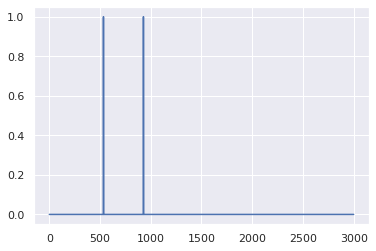

In [105]:
plt.plot(rewards)